In [1]:
#load all packages

# base packages
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

# tensorflow and keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
from keras import metrics

# sklearn
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, confusion_matrix

# self-build procedures
from roc_multiclass import roc_multiclass
from precision_recall_multiclass import precision_recall_multiclass
from load_oasis_set import load_oasis_set
from load_oasis_set_win import load_oasis_set_win
from DataGenerator import DataGenerator

# model architectures
from cnn_backbone import base_model


### Load Train Data and oversample

In [2]:
# load dataset from drive
#PATH = "/Users/josealbertodiazsalas/Documents/Alzheimer_s Dataset/train"
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset_30percentVal\\train"
IMAGE_SIZE = (208, 176)
train_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=False,              #<---
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )
                                        
# one hot encode the labels to fit into the cnn layers
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))


Found 3040 files belonging to 3 classes.


### Deconstuct Train Dataset and Prepare for Oversampling

In [3]:
# seperation of validation set
# !!! these sets are not shuffled !!!

train_big = train_ds
X1_train_big = []
y1_train_big = []
X2_train_big = []
y2_train_big = []
X3_train_big = []
y3_train_big = []


for img, label in train_ds.unbatch():
    if label.numpy()[0] == 1:
        X1_train_big.append(img.numpy())
        y1_train_big.append(label.numpy())

    if label.numpy()[1] == 1:
        X2_train_big.append(img.numpy())
        y2_train_big.append(label.numpy())

    if label.numpy()[2] == 1:
        X3_train_big.append(img.numpy())
        y3_train_big.append(label.numpy())

### Oversampling
Fill classes to match class 0 (Healthy)

In [4]:
# create dataset for class 1 -NO oversampling- (healthy)
X1_train_big = np.array(X1_train_big)
y1_train_big = np.array(y1_train_big)

In [5]:
# oversampling for class 2 (very mild)

randomPicksIdx = [np.random.choice(len(X2_train_big)) for i in range(len(X1_train_big) - len(X2_train_big))]

for i in randomPicksIdx:
    X2_train_big.append(X2_train_big[i])
    y2_train_big.append(y2_train_big[i])

X2_train_big = np.array(X2_train_big)
y2_train_big = np.array(y2_train_big)

In [6]:
# oversampling for class 3 (mild)
randomPicksIdx = [np.random.choice(len(X3_train_big)) for i in range(len(X1_train_big) - len(X3_train_big))]            # images are randomly picked

for i in randomPicksIdx:
    X3_train_big.append(X3_train_big[i])
    y3_train_big.append(y3_train_big[i])

X3_train_big = np.array(X3_train_big)
y3_train_big = np.array(y3_train_big)

### Construct full Dataset Tensor for Training

In [7]:
# combine all data sets
X_train_fullset = np.concatenate((X1_train_big,X2_train_big,X3_train_big), axis=0)
y_train_fullset = np.concatenate((y1_train_big,y2_train_big,y3_train_big), axis=0)

In [8]:
# shuffle the whole set
X_train_temp, y_train_temp = shuffle(X_train_fullset, y_train_fullset, random_state=10)

In [9]:
# finally create tensor dataset
data_generator = DataGenerator(X_train_temp, y_train_temp, batch_size = 32)

train_fullTensor = tf.data.Dataset.from_generator(
                                            data_generator,
                                            output_signature=(tf.TensorSpec(shape=(None, 208, 176, 3), dtype=tf.float32), tf.TensorSpec(shape=(None, 3), dtype=tf.float32))
                                            )

### Load Validation Set

In [10]:
# load validation dataset from drive
# set for training
#PATH = "/Users/josealbertodiazsalas/Documents/Alzheimer_s Dataset/train"
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset_30percentVal\\validation"
IMAGE_SIZE = (208, 176)
val_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=True, 
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )

# one hot encode the labels to fit into the cnn layers
val_fullTensor = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))

Found 2029 files belonging to 3 classes.


### Check Images for Integrity

f:\alzheimer-classification\envwin\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


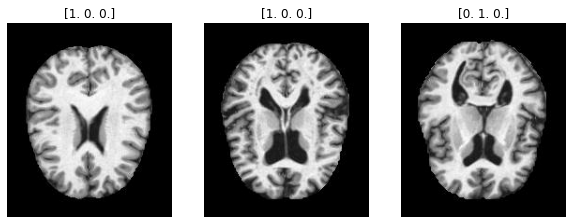

In [11]:
# plot some example images from loaded set
plt.figure(figsize=(10, 10))
for images, labels in train_fullTensor.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title([labels[i].numpy()][0])
    plt.axis("off")

# Creating CNN Architecture
### First Creating Augmentation Module 

In [12]:


with tf.device("/gpu:0"):
    data_augmentation = keras.Sequential([
        layers.InputLayer(input_shape=(208, 176, 3)),
        layers.Lambda(lambda x: tf.image.resize(x, (208, 176))),
        layers.Lambda(lambda x: tf.image.random_contrast(x,0.6,1)),
        layers.Lambda(lambda x: tf.image.random_brightness(x,0.3)),             #<--- delta value depends on image range. if 0-1 delta should be between 0-1. if 0-255 delta should be between 0-255
        layers.RandomRotation(0.01),
        layers.RandomFlip(mode="horizontal"),    
        layers.RandomZoom(0.03),
        #layers.RandomBrightness((0.2), value_range=(0,255)),
        #layers.Resizing(208, 176),
        #layers.RandomContrast((0.2))
])

### Check Images for proper Augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


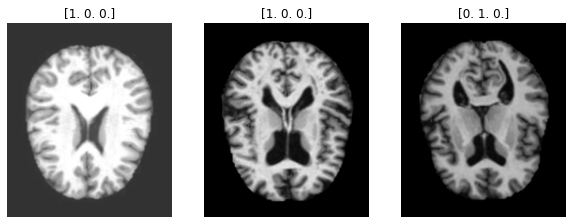

In [13]:
with tf.device("/gpu:0"):
    plt.figure(figsize=(10, 10))
    for images, labels in train_fullTensor.take(1):
        for i in range(3):
            ax = plt.subplot(1, 3, i + 1)
            img = data_augmentation(images/255)             # divided by 255 (normalization) since augmentation depends on normalization which is 
            plt.imshow(img[i].numpy(), cmap="gray")         # a specific layer in the CNN and not part of augmentation
            plt.title([labels[i].numpy()][0])
            plt.axis("off")

### Building the complete CNN
#### Construct VGG16 Backbone

In [14]:
# Defining both base and final model architecture
b_model = base_model(MODEL='VGG16', freeze_layers=False)
b_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 208, 176, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 208, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 208, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 104, 88, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 104, 88, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 104, 88, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 52, 44, 128)       0     

### Combine Backbone with Augmentation and Dense Layers

In [15]:
# Definition conv and classification layers
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(208, 176, 3)))
model.add(layers.Rescaling(1.0/255))
model.add(data_augmentation)
model.add(b_model)
model.add(layers.Flatten())
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(3, activation="softmax"))

# Print only Conv and Pooling layer from model architecture
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 208, 176, 3)       0         
                                                                 
 sequential (Sequential)     (None, 208, 176, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 6, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 15360)             0         
                                                                 
 dense (Dense)               (None, 500)               7680500   
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 500)              

### Defining the Optimizer

In [16]:
# Defining optimizer and learning rate
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.00001,
    decay_steps=10000,
    decay_rate=1,
    staircase=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')

### Compile the CNN Architecture

In [17]:
# Freeze the the behavior of that model. If any trainable value changes, compile() must be called again
keras.backend.clear_session()
model.compile(optimizer=optimizer,
    loss="CategoricalCrossentropy",
    metrics=[metrics.Precision(), metrics.Recall()])

### Train the Model
You can chose the save the model iterativly at every checkpoint by including the lines

In [18]:
# Saving model parameters and weights per epoch
#checkpoint_filepath = 'F:\\MRI_class\\data\\Alzheimer_s Dataset_20percentVal\\SimpleCNN_lr10-4\\checkpoint_model.epoch{epoch:02d}-recall{val_recall:.2f}.hdf5'
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_recall', mode='max',
#save_best_only=True)

# Model training. Model weights are saved at the end of every epoch, if it's the best seen so far
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    model_history = model.fit(x=train_fullTensor,
                        validation_data=val_fullTensor,
                        epochs=50, 
                        shuffle=True
                        #callbacks=[model_checkpoint_callback]
                        )

Epoch 1/50
144/144 [==============================] - 29s 160ms/step - loss: 1.0052 - precision: 0.6160 - recall: 0.2035 - val_loss: 0.8326 - val_precision: 0.6547 - val_recall: 0.4391
Epoch 2/50
 24/144 [====>.........................] - ETA: 14s - loss: 0.8509 - precision: 0.7051 - recall: 0.4544

KeyboardInterrupt: 

### Visualize Training Results

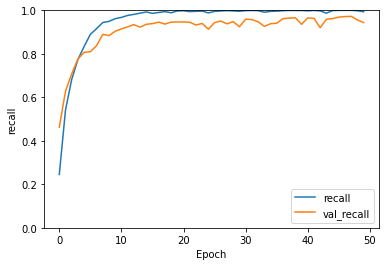

In [ ]:
plt.plot(model_history.history['recall'], label='recall')
plt.plot(model_history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

### Save the Model

In [ ]:
#model.save('F:\\MRI_class\\data\\Alzheimer_s Dataset_30percentVal\\VGG16_LR10-5_augm_Oversample\\')
#model.save('F:\\MRI_class\\data\\Alzheimer_s Dataset_30percentVal\\VGG16_LR10-5_augm_Oversample\\h5\\model_1.h5')

### Load a Testset

In [ ]:
oasis_img_temp, oasis_label_temp = load_oasis_set_win()



Image Array Shape: (231, 208, 176, 3) 

Image Count: 231 

labels: [0. 1. 2. 3.] 

Class Counts:
      ID
CDR     
0.0  131
1.0   70
2.0   28
3.0    2


### Get only classes 0, 1 and 2 of the Testset

In [ ]:
oasis_images = []
oasis_labels = []
for image,label in zip(oasis_img_temp,oasis_label_temp):
    if int(label) == 3:
        continue
    if int(label) == 0:
        #image = image/255
        oasis_images.append(cv2.flip(image,0))
        oasis_labels.append([1,0,0])
    if int(label) == 1:
        #image = image/255
        oasis_images.append(cv2.flip(image,0))
        oasis_labels.append([0,1,0])
    if int(label) == 2:
        #image = image/255
        oasis_images.append(cv2.flip(image,0))
        oasis_labels.append([0,0,1])

oasis_images = np.array(oasis_images)
oasis_labels = np.array(oasis_labels)
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


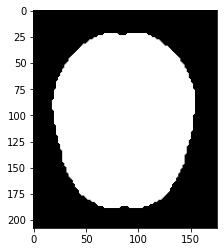

In [ ]:
plt.imshow(oasis_images[0].astype("uint8"))

### Perform a Prediction on the Testset and Visualize the Results

In [ ]:
oasis_pred = model.predict(oasis_images, batch_size=1)

229/229 [==============================] - 1s 4ms/step


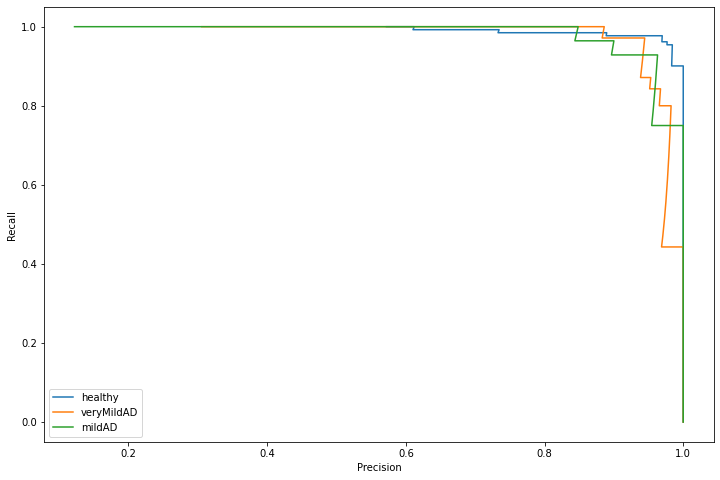

-----Recalls-----
healthy Recall: 0.9770992366412213
veryMildAD Recall: 0.9285714285714286
mildAD Recall: 0.8928571428571429
-------#####-------


-----Precisions-----
healthy Precision: 0.9552238805970149
veryMildAD Precision: 0.9420289855072463
mildAD Precision: 0.9615384615384616
-------#####-------


-----Macro Recall and Precisions-----
Macro recall: 0.9328426026899309
Macro recall: 0.9529304425475743
-------#####-------


In [ ]:
precision_recall_multiclass(oasis_pred,oasis_labels,["healthy","veryMildAD","mildAD"])